# Import files

In [1]:
from Strats.PairTradingStrat import *
from PnL_Metrics.PortfolioMetrics import *
from PnL_Metrics.WRC import *
from PnL_Metrics.Backtest import *

import warnings

warnings.filterwarnings("ignore")

# Run Strats

In [2]:
# Get all available tickers
response = requests.get(f"{BASE_URL}/ticker/price")
data = response.json()
BTC_pairs = [i["symbol"] for i in data if "BTC" in i["symbol"]]


In [ ]:
coint_pairs = get_coint_pairs(BTC_pairs, interval = '5m', start_date="2024-01-01", end_date="2024-01-31")
len(coint_pairs)

100%|██████████| 524/524 [16:11<00:00,  1.85s/it]


62

In [3]:
# test_pairs = coint_pairs[:4]
test_pairs = ['BTCUSDT', 'BNBUSDT']
print(test_pairs)

symbol_manager = BinanceSymbolManager()
# Add symbols
for t in test_pairs:
    print(symbol_manager.add_symbol(t))  # Success

price_fetcher = BinancePriceFetcher(symbol_manager.get_symbols())
# Fetch pair historical price
pair_portfolio = price_fetcher.get_grp_historical_ohlcv(
        interval="5m",
        start_date="2024-06-01",
        end_date="2024-12-31"
    )

pair_portfolio

['BTCUSDT', 'BNBUSDT']
'BTCUSDT' added successfully.
'BNBUSDT' added successfully.


,timestamp,BNBUSDT,BTCUSDT
0,2024-06-01 00:00:00,594.20,67647.88
1,2024-06-01 00:05:00,593.90,67614.21
2,2024-06-01 00:10:00,593.90,67586.61
3,2024-06-01 00:15:00,593.40,67529.45
4,2024-06-01 00:20:00,593.30,67511.97
...,...,...,...
61340,2024-12-30 23:40:00,703.29,92756.49
61341,2024-12-30 23:45:00,704.04,92725.99
61342,2024-12-30 23:50:00,705.41,92789.83
61343,2024-12-30 23:55:00,705.36,92792.05


In [11]:
model = pair_trading(pair_portfolio.copy())
spread = model.generate_signals(lookback=8640, execute_threshold=1.5, close_threshold=0.7)
spread

,timestamp,BNBUSDT,BTCUSDT,BNBUSDT_rolling_mean,BNBUSDT_rolling_std,BNBUSDT_z_scores,BNBUSDT_is_mean_revert,BNBUSDT_signal,BNBUSDT_exit_signal,BTCUSDT_rolling_mean,BTCUSDT_rolling_std,BTCUSDT_z_scores,BTCUSDT_is_mean_revert,BTCUSDT_signal,BTCUSDT_exit_signal
0,2024-06-01 00:00:00,594.20,67647.88,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0
1,2024-06-01 00:05:00,593.90,67614.21,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0
2,2024-06-01 00:10:00,593.90,67586.61,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0
3,2024-06-01 00:15:00,593.40,67529.45,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0
4,2024-06-01 00:20:00,593.30,67511.97,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61340,2024-12-30 23:40:00,703.29,92756.49,700.806693,29.254567,0.084886,0,0,1,98496.242708,3396.763758,-1.689771,1,1,0
61341,2024-12-30 23:45:00,704.04,92725.99,700.812418,29.250359,0.110343,0,0,1,98495.811920,3397.259535,-1.698375,1,1,0
61342,2024-12-30 23:50:00,705.41,92789.83,700.818333,29.246119,0.157001,0,0,1,98495.388394,3397.742783,-1.679220,1,1,0
61343,2024-12-30 23:55:00,705.36,92792.05,700.824344,29.241715,0.155109,0,0,1,98494.969882,3398.222585,-1.678207,1,1,0


In [150]:
from Utils.import_files import *
import matplotlib.pyplot as plt
from Strats.WeightAllocation import *

class Backtest:
    def __init__(self, df, tickers, test_start_date, test_end_date, stoploss=0.1, drawdown_duration=100):
        '''
        Initialize the backtesting class with necessary parameters.
        
        Args:
            df (DataFrame): DataFrame containing price and signal data: columns required - timestamp, ticker (contains price), ticker_signal, ticker_exit_signal
            tickers (list): List of tickers/symbols to backtest
            weights (list): Portfolio weights for each ticker
            test_start_date (str/datetime): Start date for backtesting period
            stoploss (float): Stop-loss percentage (default: 0.1 for 10%)
            drawdown_duration (int): Number of days to consider for drawdown (default: 100)
        '''
        self.df = df
        self.test_start_date = test_start_date
        self.test_end_date = test_end_date
        self.tickers = tickers
        self.weights = np.array([1/len(tickers) for i in tickers]) #equal weighting first
        self.stoploss = stoploss
        self.drawdown_duration = drawdown_duration
        

    def backtest(self, ticker):
        '''
        Backtest a single ticker based on trading signals.
        
        Args:
            ticker (str): The ticker symbol to backtest
            
        Returns:
            DataFrame: Contains PnL metrics and position information
        '''
        # Filter trades from the start date and reset index
        trades = self.df[(self.df['timestamp'] <= self.test_end_date) & (self.df['timestamp'] >= self.test_start_date)].copy().reset_index(drop=True)
        
        # Initialize PnL tracking variables
        position = 0  # Current position (positive for long, negative for short)
        pnlUnrealized = 0  # Unrealized profit/loss
        pnlRealized = 0  # Realized profit/loss
        
        # Price averaging for short and long positions
        avg_short_price = 0  # Average price of short positions
        short_pos = 0  # Size of short position
        avg_long_price = 0  # Average price of long positions
        long_pos = 0  # Size of long position
        closed_pos = 0  # Size of position being closed
        
        # Lists to track metrics over time
        positions = []  # Track position size at each step
        pnlUnrealized_list = []  # Track unrealized PnL
        pnlRealized_list = []  # Track realized PnL
        daily_pnl = []  # Daily PnL (realized + unrealized)
        daily_pnl_pct = []  # Daily PnL percentage change

        peak = 0
        peak_ind = len(trades)

        # Process each trade in sequence
        for i in range(0, len(trades)):
            # Get current trade information
            qty = trades[ticker+'_signal'][i]  # Signal quantity (positive for buy, negative for sell)
            price = trades[ticker][i]  # Current price
            exit_signal = trades[ticker+'_exit_signal'][i]  # Exit signal (1 = exit)

            if (pnlUnrealized + pnlRealized) > peak:
                peak = pnlUnrealized + pnlRealized
                peak_ind = i
                
            # Check exit conditions (three possible exit triggers)
            if exit_signal == 1:  # Exit signal triggered
                if position != 0:
                    qty = -position  # Close entire position
            elif (len(daily_pnl_pct) > 0) and (daily_pnl_pct[-1] < -self.stoploss):  # Stop-loss hit
                if position != 0:
                    qty = -position  # Close entire position
            elif (i - peak_ind) >= self.drawdown_duration:  # Drawdown duration exceeded
                if position != 0:
                    qty = -position  # Close entire position
                    peak_ind = len(trades)
            
            # Update position averages based on trade direction
            if qty < 0:  # Short position
                avg_short_price = (avg_short_price * short_pos + price * qty) / (short_pos + qty)
                short_pos += qty
            elif qty > 0:  # Long position
                avg_long_price = (avg_long_price * long_pos + price * qty) / (long_pos + qty)
                long_pos += qty
            
            # Handle position closing and PnL calculation
            if i > 0:  # Skip first trade as we need previous data
                if (qty * position) < 0:  # Check if we're closing part of the position
                    closed_pos = min(abs(qty), abs(position))
                else:
                    closed_pos = 0
                
                # Update position sizes
                short_pos += closed_pos
                long_pos -= closed_pos
                
                # Calculate unrealized PnL based on position direction
                if (position+qty) < 0:  # Net short position
                    pnlUnrealized = (avg_short_price - price) * -(position+qty)
                else:  # Net long position
                    pnlUnrealized = (avg_long_price - price) * (position+qty)
            
            # Update position and PnL metrics
            position += qty
            pnlRealized += (avg_short_price - avg_long_price) * closed_pos
            daily_pnl += [(avg_short_price - avg_long_price) * closed_pos + pnlUnrealized]
            
            # Append current metrics to tracking lists
            positions += [position]
            pnlUnrealized_list += [pnlUnrealized]
            pnlRealized_list += [pnlRealized]
            
            # Calculate daily PnL percentage change (handle first day case)
            try:
                daily_pnl_pct += [((pnlRealized+pnlUnrealized) - (pnlUnrealized_list[-2] + pnlRealized_list[-2])) / 
                                 abs(pnlUnrealized_list[-2] + pnlRealized_list[-2] + 1e-10)]  # Small value to avoid division by zero
            except:
                daily_pnl_pct += [np.nan]  # First day has no previous PnL
            
            # Reset average prices if positions are closed
            if short_pos == 0:
                avg_short_price = 0
            if long_pos == 0:
                avg_long_price = 0
        
        # Create final results DataFrame
        pnl_df = trades[["timestamp", ticker, ticker+"_signal"]].copy()
        pnl_df.columns = ["timestamp", "Price", "Signal"]
        pnl_df["Positions"] = positions
        pnl_df["Realized_PnL"] = pnlRealized_list
        pnl_df["Unrealized_PnL"] = pnlUnrealized_list
        pnl_df["Daily_PnL"] = daily_pnl
        pnl_df["PnL_Total"] = pnl_df["Realized_PnL"] + pnl_df["Unrealized_PnL"]
        
        return pnl_df
    
    def get_weights(self, rolling=5000, weight_method = inverse_volatility_weighting, allow_short=True):
        weights = [np.array([1/len(self.tickers) for i in self.tickers])] * rolling
        for i in range(0, len(self.df)-rolling, rolling):
            window = self.df[i:i+rolling]
            pair_backtest_temp = Backtest(window.copy(), tickers = self.tickers, test_start_date=window['timestamp'].head(1).item(), test_end_date=window['timestamp'].tail(1).item(), stoploss=0.1, drawdown_duration=100)
            returns_temp = pair_backtest_temp.get_ticker_returns(notional = 10e6)
            weights_temp = weight_method(returns_temp, allow_short=allow_short).values
            if np.isnan(weights_temp[0]):
                if len(weights) == 0:
                    weights_temp = np.array([1/len(self.tickers) for i in self.tickers])
                else:
                    weights_temp = weights[-1]
            weights += [weights_temp] * len(spread[i+rolling:i+rolling*2])
        weights_df = pd.DataFrame(weights, columns=self.tickers)[:len(self.df)]
        weights_df['timestamp'] = self.df['timestamp']
        return weights_df
    
    def computePortfolioPnL(self, rolling=5000, weight_method = inverse_volatility_weighting, allow_short=True):
        '''
        Computes the portfolio-level PnL by aggregating individual asset PnLs using their weights.
        
        Args:
            test_start_date (str/datetime): Start date for the backtesting period
            stoploss (float): Stop-loss percentage to apply to each asset (default: 0.1 for 10%)
            
        Returns:
            DataFrame: Contains timestamp and portfolio-level PnL metrics including:
                - total_daily_pnl: Weighted sum of daily PnL across all assets
                - total_pnl: Weighted sum of cumulative PnL
        '''
        # Initialize empty DataFrame to store portfolio results
        portfolioPnL = pd.DataFrame()
        weights_df = self.get_weights(rolling, weight_method, allow_short)
        weights_df = weights_df[(weights_df['timestamp'] <= self.test_end_date) & (weights_df['timestamp'] >= self.test_start_date)].copy().reset_index(drop=True)
        # Loop through each ticker in the portfolio
        for ind, t in enumerate(self.tickers):
            pnl_df = self.backtest(t)
            
            # Store individual asset metrics
            portfolioPnL[t+"_daily_pnl"] = pnl_df["Daily_PnL"]
            
            # Calculate weighted portfolio metrics
            if ind > 0:
                # For subsequent assets, add weighted contribution to existing totals
                portfolioPnL["total_daily_pnl"] = portfolioPnL["total_daily_pnl"] + portfolioPnL[t+"_daily_pnl"] * weights_df[t]
                portfolioPnL["total_pnl"] = portfolioPnL["total_pnl"] + pnl_df["PnL_Total"] * weights_df[t]
            else:
                # For first asset, initialize totals with weighted values
                portfolioPnL["total_daily_pnl"] = portfolioPnL[t+"_daily_pnl"] * weights_df[t]
                portfolioPnL["total_pnl"] = pnl_df["PnL_Total"] * weights_df[t]
        
        # Add timestamp from the last backtested asset (all should have same dates)
        portfolioPnL["timestamp"] = pnl_df["timestamp"]
        
        # Select and return only the portfolio-level metrics
        portfolioPnL = portfolioPnL[["timestamp", "total_daily_pnl", "total_pnl"]]
        
        return portfolioPnL

    def plot_pnl(self):
        '''
        Visualizes the PnL performance of individual assets and the overall portfolio.
        
        Args:
            test_start_date (str/datetime): Start date for the backtesting period
            
        Returns:
            None (displays matplotlib plot)
        '''
        # Create subplots: one for each asset + one for portfolio
        fig, axs = plt.subplots(len(self.tickers)+1, 1, figsize=(15,9), sharex=True)
        
        # Plot each asset's PnL in separate subplot
        for i, t in enumerate(self.tickers):
            # Backtest the asset
            pnl_df = self.backtest(t)
            
            # Plot cumulative PnL
            axs[i].plot(pnl_df["timestamp"], pnl_df["PnL_Total"], label=f"{t}_PnL_Total")
            axs[i].set_ylabel("Accumulated PnL")
            axs[i].set_xlabel("timestamp")
            axs[i].legend()
            axs[i].grid(True)
        
        # Calculate and plot portfolio PnL in bottom subplot
        total_pnl_df = self.computePortfolioPnL()
        axs[len(self.tickers)].plot(total_pnl_df["timestamp"], total_pnl_df["total_pnl"], label="Portfolio")
        axs[len(self.tickers)].set_ylabel("Accumulated PnL")
        axs[len(self.tickers)].set_xlabel("timestamp")
        axs[len(self.tickers)].legend()
        axs[len(self.tickers)].grid(True)
        
        # Display the complete figure
        plt.show()

    def get_ticker_returns(self, notional = 10e6):
        grp_returns = pd.DataFrame()
        for t in self.tickers:
            pnl = self.backtest(t)['PnL_Total']
            pnl_diff = np.diff(pnl)
            grp_returns[t+'_returns'] = pnl_diff / notional

        return grp_returns
    
    def get_window_ticker_returns(self, notional = 10e6):
        grp_returns = pd.DataFrame()
        for t in self.tickers:
            pnl = self.backtest(t)['PnL_Total']
            pnl_diff = np.diff(pnl)
            grp_returns[t+'_returns'] = pnl_diff / notional

        return grp_returns
    
    def get_returns(self, notional = 10e6):
        pnl_df = self.computePortfolioPnL()
        pnl_diff = np.diff(pnl_df['total_pnl'])
        returns = pnl_diff / notional
        return returns

In [151]:
pair_backtest = Backtest(spread.copy(), tickers = test_pairs, test_start_date="2024-07-01", test_end_date="2024-12-31", stoploss=0.05, drawdown_duration=5000)
pair_pnl_df = pair_backtest.computePortfolioPnL(rolling=500)
pair_pnl_df

,timestamp,total_daily_pnl,total_pnl
0,2024-07-01 00:00:00,0.000000,0.000000
1,2024-07-01 00:05:00,0.000000,0.000000
2,2024-07-01 00:10:00,0.000000,0.000000
3,2024-07-01 00:15:00,0.000000,0.000000
4,2024-07-01 00:20:00,0.000000,0.000000
...,...,...,...
52700,2024-12-30 23:40:00,981.927264,92404.922467
52701,2024-12-30 23:45:00,795.284873,92218.280076
52702,2024-12-30 23:50:00,1200.974351,92623.969554
52703,2024-12-30 23:55:00,1215.604478,92638.599681


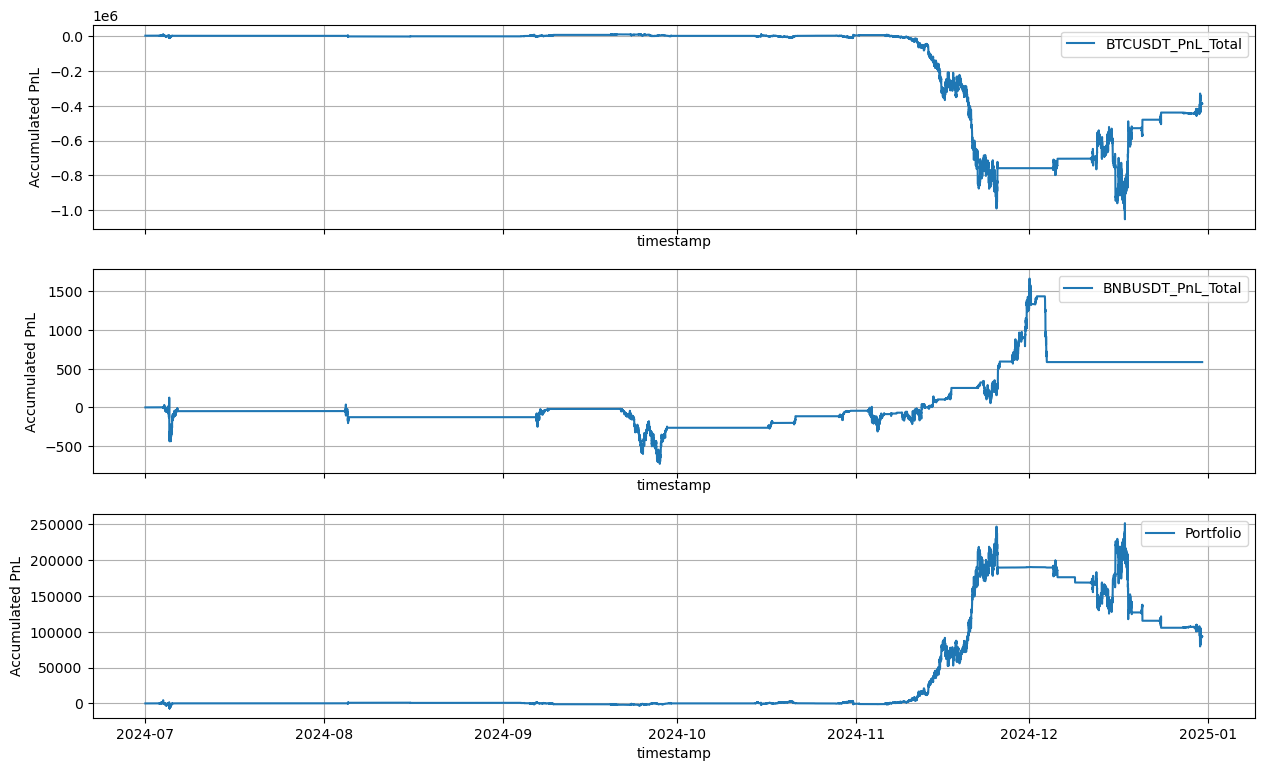

In [152]:
pair_backtest.plot_pnl()

In [130]:
# Fetch pair historical price
pair_portfolio_momentum = pair_portfolio[pair_portfolio["timestamp"] >= "2024-07-01"].reset_index(drop=True)


# Initialize strategy
momentum = MomentumStrat(data=pair_portfolio_momentum)

momentum_df = momentum.momentum_strategy(lookback=30, hold_period=10)
momentum_df

,timestamp,BNBUSDT,BTCUSDT,BNBUSDT_signal,BNBUSDT_exit_signal,BTCUSDT_signal,BTCUSDT_exit_signal
0,2024-07-01 00:00:00,582.00,62722.08,NaN,NaN,NaN,NaN
1,2024-07-01 00:05:00,580.60,62648.49,NaN,NaN,NaN,NaN
2,2024-07-01 00:10:00,580.40,62624.00,NaN,NaN,NaN,NaN
3,2024-07-01 00:15:00,581.00,62682.02,NaN,NaN,NaN,NaN
4,2024-07-01 00:20:00,581.30,62674.01,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
52700,2024-12-30 23:40:00,703.29,92756.49,0.0,0.0,0.0,0.0
52701,2024-12-30 23:45:00,704.04,92725.99,0.0,0.0,0.0,0.0
52702,2024-12-30 23:50:00,705.41,92789.83,0.0,0.0,0.0,0.0
52703,2024-12-30 23:55:00,705.36,92792.05,0.0,0.0,0.0,0.0


In [131]:
momentum_backtest = Backtest(momentum_df.copy(), tickers = test_pairs, test_start_date="2024-07-01", test_end_date="2024-12-31", stoploss=0.1, drawdown_duration=100)
momentum_pnl_df = momentum_backtest.computePortfolioPnL()
momentum_pnl_df

,timestamp,total_daily_pnl,total_pnl
0,2024-07-01 00:00:00,0.0,0.0
1,2024-07-01 00:05:00,NaN,NaN
2,2024-07-01 00:10:00,NaN,NaN
3,2024-07-01 00:15:00,NaN,NaN
4,2024-07-01 00:20:00,NaN,NaN
...,...,...,...
52700,2024-12-30 23:40:00,NaN,NaN
52701,2024-12-30 23:45:00,NaN,NaN
52702,2024-12-30 23:50:00,NaN,NaN
52703,2024-12-30 23:55:00,NaN,NaN


# Comparison

In [142]:
pair_returns = pair_backtest.get_returns(notional = 10e6)
# momentum_returns = momentum_backtest.get_returns(notional = 10e6)

returns = pd.DataFrame()
# returns["Momentum"] = momentum_returns
returns["Pair_Trade"] = pair_returns

port_metrics = PortfolioMetrics(returns.dropna(), periods_per_year=252*12*24)
summary = port_metrics.summary(risk_free_rate=0)
print(summary)

            Annualized Return  Annualized Volatility  Sharpe Ratio  \
Pair_Trade           0.013358               0.020823      0.647682   

            Max Drawdown Duration  Max Drawdown  Calmar Ratio  Skewness  \
Pair_Trade                  37259     -0.017665      0.756191 -0.561828   

              Kurtosis  VaR (5%)  CVaR (5%)  Tail Ratio  Omega Ratio  
Pair_Trade  119.209254 -0.000024  -0.000161    1.038968     1.021653  


In [28]:
wrc = WhiteRealityCheck(strategies=returns["Pair_Trade"], benchmark=returns["Momentum"])
wrc.run()
wrc.superior_strategies()

White Reality Check Results:
p-value: lower         0.097
consistent    0.097
upper         0.097
dtype: float64
Superior strategy indices:
[]


[]